Import and required packages

In [150]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pycaret
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
employeedata=pd.read_excel('/content/drive/MyDrive/Job A thon/train_MpHjUjU.xlsx')

Checking parameters null and categories

In [152]:
#import modules
import pandas  # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
% matplotlib inline

In [153]:
employeedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Emp_ID                19104 non-null  int64         
 2   Age                   19104 non-null  int64         
 3   Gender                19104 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Salary                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Designation           19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [154]:
employeedata['MMM-YY'].describe()

count                   19104
unique                     24
top       2016-01-01 00:00:00
freq                     1022
first     2016-01-01 00:00:00
last      2017-12-01 00:00:00
Name: MMM-YY, dtype: object

Feature Engineering

In [155]:
uniqueemployeesdata= employeedata[['Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'Joining Designation',
       'Designation']].drop_duplicates()

Getting Target column set

In [156]:
employeeswholeft=employeedata[~employeedata['LastWorkingDate'].isna()]
employeeswholeft['Y']=0
uniqueemployeesdata=uniqueemployeesdata.merge(employeeswholeft[['Emp_ID','Y']],on='Emp_ID',how='left')
uniqueemployeesdata['Y']=uniqueemployeesdata['Y'].fillna(1)

Time with company

In [157]:
employeeage=employeedata.groupby('Emp_ID').count()['City']
employeeage=employeeage.reset_index()
employeeage.columns=['Emp_ID','Periodwithus']
uniqueemployeesdata=uniqueemployeesdata.merge(employeeage,on='Emp_ID',how='left')

Average business done each month and Rating

In [158]:
uniqueemployeesdata= uniqueemployeesdata.merge(pd.pivot_table(employeedata,index='Emp_ID',values=['Total Business Value','Quarterly Rating'],aggfunc='mean').reset_index(),on='Emp_ID',how='left')

Times business done

In [159]:
uniqueemployeesdata['timesbusinessdone']=uniqueemployeesdata['Total Business Value']/uniqueemployeesdata['Salary']

reversals happened for employees

In [160]:
reversals = employeedata[employeedata['Total Business Value']<0]
reversals['reversal']=1
uniqueemployeesdata=uniqueemployeesdata.merge(reversals[['Emp_ID','reversal']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['reversal']=uniqueemployeesdata['reversal'].fillna(0)

zero business count

In [161]:
zeroperformance = employeedata[employeedata['Total Business Value']==0]
zeroperformance=zeroperformance.groupby('Emp_ID').count()['Age'].reset_index()
zeroperformance.columns=['Emp_ID','zeroperformance']
uniqueemployeesdata=uniqueemployeesdata.merge(zeroperformance.drop_duplicates(),on='Emp_ID',how='left')

Months when coverage less than salary

In [162]:
employeedata['timesbusiness']=employeedata['Total Business Value']/employeedata['Salary']
businesslesscoverage = employeedata[employeedata['timesbusiness']<1]
businesslesscoverage=businesslesscoverage.groupby('Emp_ID').count()['Age'].reset_index()
businesslesscoverage.columns=['Emp_ID','Businesslessthansalary']
uniqueemployeesdata=uniqueemployeesdata.merge(businesslesscoverage[['Emp_ID','Businesslessthansalary']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['Businesslessthansalary']=uniqueemployeesdata['Businesslessthansalary'].fillna(0)

Designation change

In [163]:
changedesignation=employeedata[employeedata['Joining Designation']!=employeedata['Designation']]
changedesignation['changedesignation']=1
changedesignation=changedesignation[['Emp_ID','changedesignation']].drop_duplicates()
uniqueemployeesdata=uniqueemployeesdata.merge(changedesignation[['Emp_ID','changedesignation']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['changedesignation']=uniqueemployeesdata['changedesignation'].fillna(0)

Last rating before leaving

In [164]:
lastrating= employeedata[['Emp_ID','Quarterly Rating']].drop_duplicates( subset='Emp_ID',keep='last')
lastrating.columns=['Emp_ID','Last Rating']
uniqueemployeesdata=uniqueemployeesdata.merge(lastrating,on='Emp_ID',how='left')

Checking correlation 

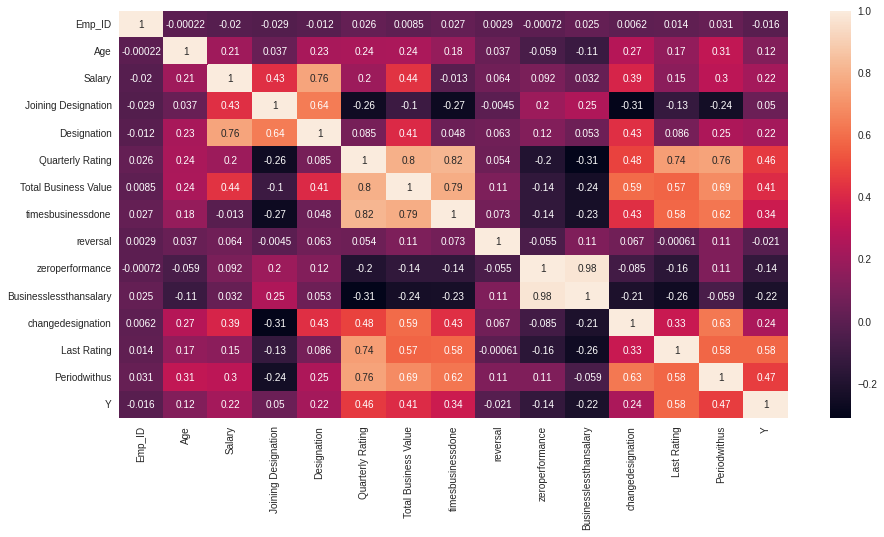

In [165]:
plt.figure(figsize=(15,7.5))
uniqueemployeesdata=uniqueemployeesdata[['Emp_ID', 'Age', 'City', 'Education_Level', 'Salary', 'Dateofjoining',
       'Joining Designation', 'Designation', 'Quarterly Rating',
       'Total Business Value', 'Gender',
       'timesbusinessdone','reversal','zeroperformance','Businesslessthansalary','changedesignation','Last Rating','Periodwithus','Y']]
df4_corr=uniqueemployeesdata.corr()
sns.heatmap(df4_corr,annot=True)

Model Building

In [166]:
from pycaret.classification import *
s = setup(uniqueemployeesdata, target = 'Y', ignore_features = ['Emp_ID','Dateofjoining'])

,Description,Value
0,session_id,6647
1,Target,Y
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(3786, 19)"
5,Missing Values,True
6,Numeric Features,7
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


Model performance

In [167]:
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8921,0.9528,0.8273,0.8849,0.8548,0.7691,0.7706,0.618
rf,Random Forest Classifier,0.9072,0.9496,0.8322,0.9187,0.8730,0.8002,0.8029,0.661
lightgbm,Light Gradient Boosting Machine,0.8928,0.9442,0.8106,0.9010,0.8529,0.7691,0.7722,0.147
gbc,Gradient Boosting Classifier,0.8604,0.9241,0.7478,0.8716,0.8044,0.6969,0.7023,0.522
ada,Ada Boost Classifier,0.8408,0.9059,0.7272,0.8383,0.7779,0.6549,0.6597,0.209
lda,Linear Discriminant Analysis,0.8200,0.8658,0.6908,0.8151,0.7472,0.6089,0.6145,0.049
dt,Decision Tree Classifier,0.8687,0.8583,0.8135,0.8407,0.8261,0.7207,0.7218,0.035
knn,K Neighbors Classifier,0.7140,0.7635,0.5653,0.6467,0.6013,0.3805,0.3838,0.139
nb,Naive Bayes,0.7283,0.7474,0.4201,0.7687,0.5418,0.3723,0.4071,0.020
lr,Logistic Regression,0.7147,0.7242,0.4858,0.6874,0.5629,0.3622,0.3775,0.295


In [168]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8415,0.8872,0.7451,0.8261,0.7835,0.6590,0.6612
1,0.8075,0.8763,0.7843,0.7339,0.7583,0.5987,0.5996
2,0.8113,0.8767,0.6961,0.7889,0.7396,0.5926,0.5954
3,0.7849,0.8466,0.7157,0.7228,0.7192,0.5449,0.5449
4,0.8038,0.8810,0.7255,0.7551,0.7400,0.5825,0.5828
5,0.8528,0.8940,0.7745,0.8316,0.8020,0.6851,0.6862
6,0.7736,0.8420,0.6471,0.7333,0.6875,0.5111,0.5135
7,0.8340,0.9103,0.7647,0.7959,0.7800,0.6468,0.6471
8,0.8264,0.8938,0.7647,0.7800,0.7723,0.6321,0.6321
9,0.7660,0.8462,0.7030,0.6893,0.6961,0.5059,0.5060


Performance of coverage

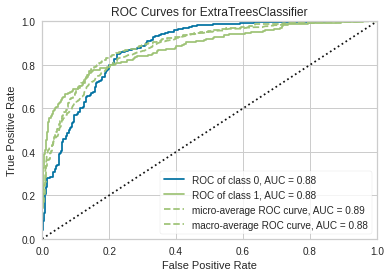

In [169]:
plot_model(tuned_best_model, plot = 'auc')

Feature importance

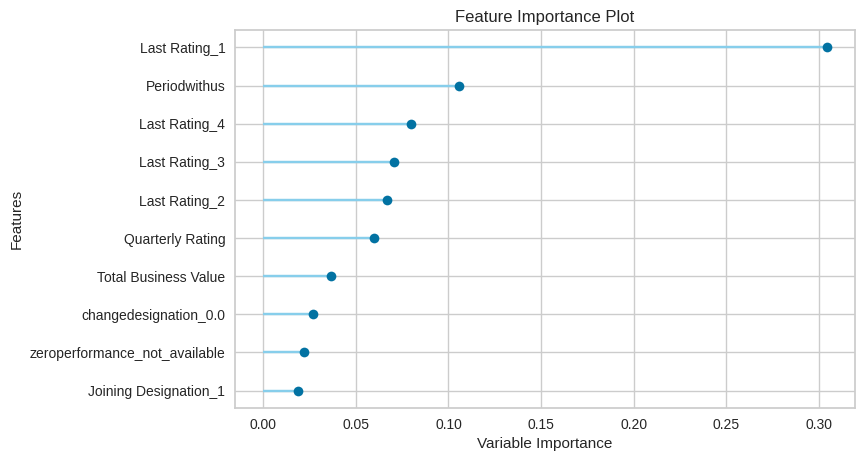

In [170]:
plot_model(tuned_best_model, plot = 'feature')

Confusion matrix

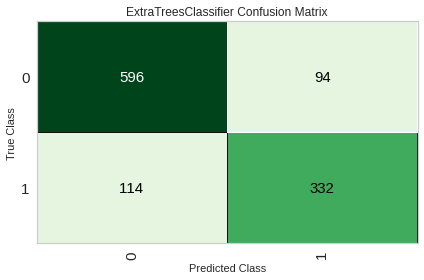

In [171]:
plot_model(tuned_best_model, plot = 'confusion_matrix')

Test Set

In [172]:
test=pd.read_csv('/content/drive/MyDrive/Job A thon/test_hXY9mYw.csv')

In [173]:
testset=uniqueemployeesdata[uniqueemployeesdata['Emp_ID'].isin(test['Emp_ID'])]
testset= testset.drop_duplicates()

In [174]:
et = create_model('et')
tuned_et = tune_model(et)
predict_model(tuned_et)
final_et = finalize_model(tuned_et)
unseen_predictions = predict_model(final_et, data=testset)
predictionsfinal= unseen_predictions[['Emp_ID','Label']].drop_duplicates()


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8415,0.8872,0.7451,0.8261,0.7835,0.6590,0.6612
1,0.8075,0.8763,0.7843,0.7339,0.7583,0.5987,0.5996
2,0.8113,0.8767,0.6961,0.7889,0.7396,0.5926,0.5954
3,0.7849,0.8466,0.7157,0.7228,0.7192,0.5449,0.5449
4,0.8038,0.8810,0.7255,0.7551,0.7400,0.5825,0.5828
5,0.8528,0.8940,0.7745,0.8316,0.8020,0.6851,0.6862
6,0.7736,0.8420,0.6471,0.7333,0.6875,0.5111,0.5135
7,0.8340,0.9103,0.7647,0.7959,0.7800,0.6468,0.6471
8,0.8264,0.8938,0.7647,0.7800,0.7723,0.6321,0.6321
9,0.7660,0.8462,0.7030,0.6893,0.6961,0.5059,0.5060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8169,0.8786,0.7444,0.7793,0.7615,0.613,0.6134


In [175]:
predictionsfinal= predictionsfinal.drop_duplicates( subset='Emp_ID',keep='last')
predictionsfinal.to_csv('predictions.csv')